In [25]:
import os
import numpy as np
np.random.seed(1)
import random as rn
rn.seed(1)
import tensorflow as tf
tf.random.set_seed(1)
from keras import Sequential
from keras.layers import Dense, Dropout, Input, concatenate
from keras.wrappers.scikit_learn import KerasRegressor
from keras import Model
from sklearn.ensemble import RandomForestRegressor
import config
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
import math

In [26]:
def mean_abs_pct_error(y, y_pred, **kwargs):
    arr = abs(y_pred - y) / y
    return np.mean(arr)

In [27]:
def create_model(neurons=4, act='relu', opt='adam', loss='mean_absolute_error', dropout_rate=0, kernel='uniform'):
    model = Sequential()
    model.add(Dropout(dropout_rate, input_shape=(n_inputs,)))
    model.add(Dense(neurons, activation=act))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [28]:
engine = config.engine

In [29]:
qry = 'SELECT * FROM train_cleaned ' \
      'UNION ' \
      'SELECT * FROM test_cleaned;'

data = pd.read_sql(sql=qry, con=engine)

### Re-split tabular data to match geographic split used for feature extraction

In [30]:
test_lsoas = [
    'E01017935',
    'E01017904',
    'E01017900',
    'E01017858',
    'E01017871',
    'E01017867',
    'E01017938',
    'E01017859',
    'E01017936',
    'E01017907']

In [31]:
cols = ['energy_consumption_current', 'total_floor_area',
       'number_open_fireplaces', 'mainheatc_energy_eff', 'barriers_score',
       'cyp_score', 'older_pop_60', 'ptype_F', 'ptype_S', 'ptype_T',
       'new_build_Y', 'mains_gas_flag_Y',
       'construction_age_band_England and Wales: before 1900',
       'price']

In [32]:
combined_data = pd.get_dummies(data)
X = combined_data[cols]
X_test = X[data['lsoa_code'].isin(test_lsoas)]
X_train = X[~data['lsoa_code'].isin(test_lsoas)]

y_train = X_train.pop('price').apply(np.log)
y_test = X_test.pop('price').apply(np.log)

In [33]:
X_train.shape, X_test.shape

((2227, 13), (340, 13))

In [34]:
X_train.columns

Index(['energy_consumption_current', 'total_floor_area',
       'number_open_fireplaces', 'mainheatc_energy_eff', 'barriers_score',
       'cyp_score', 'older_pop_60', 'ptype_F', 'ptype_S', 'ptype_T',
       'new_build_Y', 'mains_gas_flag_Y',
       'construction_age_band_England and Wales: before 1900'],
      dtype='object')

In [35]:
X_train.head()

,energy_consumption_current,total_floor_area,number_open_fireplaces,mainheatc_energy_eff,barriers_score,cyp_score,older_pop_60,ptype_F,ptype_S,ptype_T,new_build_Y,mains_gas_flag_Y,construction_age_band_England and Wales: before 1900
0,377,64.96,0.0,1,21.025,0.314,250,1,0,0,0,0,0
1,275,86.00,0.0,2,23.975,-0.325,261,0,1,0,0,1,1
2,175,84.48,0.0,3,16.241,0.718,259,0,0,1,0,1,0
3,327,106.00,0.0,3,21.025,0.314,250,0,1,0,0,1,0
4,154,130.00,0.0,3,8.620,-1.121,459,0,1,0,0,1,0


In [36]:
X_train.loc[:, 'total_floor_area'] = X_train.loc[:, 'total_floor_area'].apply(np.log)
X_test.loc[:, 'total_floor_area'] = X_test.loc[:, 'total_floor_area'].apply(np.log)

C:\Users\neils\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [37]:
X_train.shape

(2227, 13)

In [38]:
X_test.shape

(340, 13)

In [39]:
scale = MinMaxScaler()

In [40]:
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [129]:
mean_errors_list = []
median_errors_list = []
r2_list = []
errors_summary_list = []

### Retraining and testing the baseline models on the geographically split data

#### Linear Regression

In [41]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_y_pred = lr.predict(X_test_scaled)

In [42]:
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error

In [130]:
lr_test_mae = round(mean_absolute_error(y_test, lr_y_pred), 3)
lr_test_med = round(median_absolute_error(y_test, lr_y_pred), 3)
lr_test_r2 = round(r2_score(y_test, lr_y_pred), 3)
print(f'Test mean absolute error: {lr_test_mae}')
print(f'Test median absolute_error: {lr_test_med}')
print(f'Test r2: {lr_test_r2}')
mean_errors_list.append(lr_test_mae)
median_errors_list.append(lr_test_med)
r2_list.append(lr_test_r2)

Test mean absolute error: 0.138
Test median absolute_error: 0.105
Test r2: 0.804


In [131]:
lr_errors = abs(lr_y_pred - y_test)
errors_summary_list.append(lr_errors.describe())
lr_errors.describe()

count    340.000000
mean       0.138417
std        0.126078
min        0.000088
25%        0.049779
50%        0.105249
75%        0.203604
max        0.939933
Name: price, dtype: float64

#### Random Forest

In [45]:
np.random.seed(1)
rf = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=3)
rf.fit(X_train_scaled, y_train)

rf_y_pred = rf.predict(X_test_scaled)

In [132]:
rf_test_mae = round(mean_absolute_error(y_test, rf_y_pred), 3)
rf_test_med = round(median_absolute_error(y_test, rf_y_pred), 3)
rf_test_r2 = round(r2_score(y_test, rf_y_pred), 3)
print(f'Test mean absolute error: {rf_test_mae}')
print(f'Test median absolute_error: {rf_test_med}')
print(f'Test r2: {rf_test_r2}')
mean_errors_list.append(rf_test_mae)
median_errors_list.append(rf_test_med)
r2_list.append(rf_test_r2)

Test mean absolute error: 0.139
Test median absolute_error: 0.114
Test r2: 0.802


In [133]:
rf_errors = abs(rf_y_pred - y_test)
errors_summary_list.append(rf_errors.describe())
rf_errors.describe()

count    340.000000
mean       0.139039
std        0.126950
min        0.000602
25%        0.051943
50%        0.113738
75%        0.185558
max        1.144303
Name: price, dtype: float64

#### ANN ensemble

In [48]:
# Ensemble
n_inputs = X_train_scaled.shape[1]

ensemble_y_preds = []

#best params for 13 features dataset from baseline models
neurons = 64
batch_size = 10
dropout_rate = 0
epochs = 100

tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
i = 0
while i < 10:
    model = create_model(neurons=neurons, dropout_rate=dropout_rate)
    history = model.fit(X_train_scaled,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=0,
                        validation_split=0.2)
    if max(history.history['loss']) - min(history.history['loss']) > 1:
        y_pred = model.predict(X_test_scaled)
        ensemble_y_preds.append(y_pred)
        i += 1
    else:
        continue

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_11 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [50]:
ensemble_y_pred_means = np.array(ensemble_y_preds).mean(axis=0).reshape(len(ensemble_y_preds[0]))

In [134]:
ensemble_test_mae = round(mean_absolute_error(y_test, ensemble_y_pred_means), 3)
ensemble_test_med = round(median_absolute_error(y_test, ensemble_y_pred_means), 3)
ensemble_test_r2 = round(r2_score(y_test, ensemble_y_pred_means), 3)
print(f'Test mean absolute error: {ensemble_test_mae}')
print(f'Test median absolute_error: {ensemble_test_med}')
print(f'Test r2: {ensemble_test_r2}')
mean_errors_list.append(ensemble_test_mae)
median_errors_list.append(ensemble_test_med)
r2_list.append(ensemble_test_r2)

Test mean absolute error: 0.135
Test median absolute_error: 0.102
Test r2: 0.806


In [135]:
ensemble_errors = abs(ensemble_y_pred_means - y_test)
errors_summary_list.append(ensemble_errors.describe())
ensemble_errors.describe()

count    340.000000
mean       0.135142
std        0.128027
min        0.000685
25%        0.049574
50%        0.101875
75%        0.190493
max        0.974559
Name: price, dtype: float64

### With visual features

#### Get Basic CNN features

In [56]:
basic_cnn_features = pd.read_pickle('visual_features_BasicCNN.pkl')
basic_cnn_features.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
postcode,,,,,,,,,,,,,,,,,,,,,
HP13 6HH,0.460285,0.609173,-1.033105,-1.140801,0.867461,-0.389387,-1.112721,0.519766,1.213608,-1.294701,...,-1.143036,0.281333,-0.115862,1.481613,2.317501,1.040266,1.199460,1.391251,-0.780336,-1.210949
HP13 6EA,0.937270,0.377074,-1.033105,-0.967907,1.365271,0.137931,-1.112721,1.068601,0.993053,-1.294701,...,-1.143036,0.092861,0.266590,1.715756,2.274577,0.796801,0.761629,0.984326,-0.934701,-1.210949
HP13 6XJ,0.598973,0.752545,-1.033105,-1.100252,0.938736,-0.158266,-1.112721,1.378435,0.857829,-1.294701,...,-1.143036,0.283934,0.288493,1.659969,1.771476,0.827088,1.049534,1.116665,-0.417524,-1.210949
HP13 6DN,-0.994475,1.282921,-1.033105,0.855755,0.505091,-0.990967,-1.112721,-0.354120,1.602455,-1.294701,...,-1.143036,-0.566145,-1.531380,2.605138,3.682518,2.122008,1.654604,2.484123,-1.635064,-1.210949
HP13 6DZ,-0.088234,1.141260,-1.033105,-0.121967,0.747035,-0.544591,-1.112721,0.108471,1.391343,-1.294701,...,-1.143036,-0.212643,-0.750765,1.923859,2.900778,1.546351,1.250457,1.797178,-1.165277,-1.210949


In [59]:
features_matched = data.merge(basic_cnn_features,
                               how='left',
                               left_on='postcode',
                               right_index=True)

basic_cnn_train_features = features_matched.loc[~data.lsoa_code.isin(test_lsoas), basic_cnn_features.columns]
basic_cnn_test_features = features_matched.loc[data.lsoa_code.isin(test_lsoas), basic_cnn_features.columns]

In [60]:
# scale features
scale = MinMaxScaler()

basic_cnn_train_features = scale.fit_transform(basic_cnn_train_features)
basic_cnn_test_features = scale.transform(basic_cnn_test_features)

In [61]:
basic_cnn_train_features.shape, basic_cnn_test_features.shape

((2227, 64), (340, 64))

#### Get ResNet50 features

In [62]:
resnet50_features = pd.read_pickle('visual_features_ResNet50.pkl')
resnet50_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
postcode,,,,,,,,,,,,,,,,,,,,,
HP13 6HH,0.0,0.0,0.183676,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.741024,0.0,0.0
HP13 6EA,0.0,0.0,0.014008,0.0,0.066264,0.0,0.000000,0.0,0.04687,0.068429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.807945,0.0,0.0
HP13 6XJ,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.837047,0.0,0.0
HP13 6DN,0.0,0.0,0.535695,0.0,0.000000,0.0,0.013951,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.059574,0.0,0.0
HP13 6DZ,0.0,0.0,0.355928,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.380399,0.0,0.0


In [63]:
resnet50_features = resnet50_features.loc[:, ~(resnet50_features == 0).all()]

In [66]:
features_matched = data.merge(resnet50_features,
                               how='left',
                               left_on='postcode',
                               right_index=True)

resnet50_train_features = features_matched.loc[~data.lsoa_code.isin(test_lsoas), resnet50_features.columns]
resnet50_test_features = features_matched.loc[data.lsoa_code.isin(test_lsoas), resnet50_features.columns]

In [67]:
scale = MinMaxScaler()

In [68]:
resnet50_train_features = scale.fit_transform(resnet50_train_features)
resnet50_test_features = scale.transform(resnet50_test_features)

In [69]:
resnet50_train_features.shape, resnet50_test_features.shape

((2227, 1390), (340, 1390))

#### Fully connected / single input approach Architecture A

#### Basic CNN features

In [70]:
# combine tabular and visual features into one table
basic_cnn_A_train = np.concatenate([X_train_scaled, basic_cnn_train_features], axis=1)
basic_cnn_A_train.shape

(2227, 77)

In [71]:
basic_cnn_A_test = np.concatenate([X_test_scaled, basic_cnn_test_features], axis=1)
basic_cnn_A_test.shape

(340, 77)

In [72]:
basic_cnn_A_y_preds = []
basic_cnn_A_histories = []

batch_size = 10
epochs = 100
features_shape = basic_cnn_A_train.shape[1] 

tf.random.set_seed(1)
i = 0
bad = 0
while i < 10:
    combined_input = Input(shape=(features_shape,))

    combined_model = Dense(128, activation='relu')(combined_input)
    combined_model = Dense(1, activation='relu')(combined_model)

    model = Model(inputs=combined_input, outputs=combined_model)
    model.compile(optimizer='adam', loss='mean_absolute_error')

    history = model.fit(basic_cnn_A_train,
              y_train, epochs=epochs,
              validation_split=0.2,
              batch_size=batch_size,
              verbose=0)
    if max(history.history['loss']) - min(history.history['loss']) > 1:
        y_pred = model.predict(basic_cnn_A_test)
        basic_cnn_A_y_preds.append(y_pred)
        basic_cnn_A_histories.append(history)
        i += 1
    else:
        bad += 1
        continue
        
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 77)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               9984      
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 129       
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


In [73]:
basic_cnn_A_y_pred = np.mean(np.array(basic_cnn_A_y_preds), axis=0)

In [136]:
basic_cnn_A_test_mae = round(mean_absolute_error(y_test, basic_cnn_A_y_pred), 3)
basic_cnn_A_test_med = round(median_absolute_error(y_test, basic_cnn_A_y_pred), 3)
basic_cnn_A_test_r2 = round(r2_score(y_test, basic_cnn_A_y_pred), 3)
print(f'Test mean absolute error: {basic_cnn_A_test_mae}')
print(f'Test median absolute_error: {basic_cnn_A_test_med}')
print(f'Test r2: {basic_cnn_A_test_r2}')
mean_errors_list.append(basic_cnn_A_test_mae)
median_errors_list.append(basic_cnn_A_test_med)
r2_list.append(basic_cnn_A_test_r2)

Test mean absolute error: 0.143
Test median absolute_error: 0.112
Test r2: 0.795


In [137]:
basic_cnn_A_errors = abs(basic_cnn_A_y_pred.reshape(len(y_pred)) - y_test)
errors_summary_list.append(basic_cnn_A_errors.describe())
basic_cnn_A_errors.describe()

count    340.000000
mean       0.142780
std        0.127774
min        0.000508
25%        0.054153
50%        0.112492
75%        0.190070
max        0.959791
Name: price, dtype: float64

#### ResNet50 features

In [80]:
# combine tabular and visual features into one table
resnet50_A_train = np.concatenate([X_train_scaled, resnet50_train_features], axis=1)
resnet50_A_train.shape

(2227, 1403)

In [81]:
resnet50_A_test = np.concatenate([X_test_scaled, resnet50_test_features], axis=1)
resnet50_A_test.shape

(340, 1403)

In [82]:
resnet50_A_y_preds = []
resnet50_A_histories = []

batch_size = 10
epochs = 100
features_shape = resnet50_A_train.shape[1] 

tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
i = 0
bad = 0
while i < 10:
    combined_input = Input(shape=(features_shape,))

    combined_model = Dense(128, activation='relu')(combined_input)
    combined_model = Dense(1, activation='relu')(combined_model)

    model = Model(inputs=combined_input, outputs=combined_model)
    model.compile(optimizer='adam', loss='mean_absolute_error')

    history = model.fit(resnet50_A_train,
              y_train, epochs=epochs,
              validation_split=0.2,
              batch_size=batch_size,
              verbose=0)
    if max(history.history['loss']) - min(history.history['loss']) > 1:
        y_pred = model.predict(resnet50_A_test)
        resnet50_A_y_preds.append(y_pred)
        resnet50_A_histories.append(history)
        i += 1
    else:
        bad += 1
        continue
        
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 1403)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               179712    
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 129       
Total params: 179,841
Trainable params: 179,841
Non-trainable params: 0
_________________________________________________________________


In [83]:
resnet50_A_y_pred = np.mean(np.array(resnet50_A_y_preds), axis=0)

In [138]:
resnet50_A_test_mae = round(mean_absolute_error(y_test, resnet50_A_y_pred), 3)
resnet50_A_test_med = round(median_absolute_error(y_test, resnet50_A_y_pred), 3)
resnet50_A_test_r2 = round(r2_score(y_test, resnet50_A_y_pred), 3)
print(f'Test mean absolute error: {resnet50_A_test_mae}')
print(f'Test median absolute_error: {resnet50_A_test_med}')
print(f'Test r2: {resnet50_A_test_r2}')
mean_errors_list.append(resnet50_A_test_mae)
median_errors_list.append(resnet50_A_test_med)
r2_list.append(resnet50_A_test_r2)

Test mean absolute error: 1.133
Test median absolute_error: 0.511
Test r2: -35.557


In [139]:
resnet50_A_errors = abs(resnet50_A_y_pred.reshape(len(y_pred)) - y_test)
errors_summary_list.append(resnet50_A_errors.describe())
resnet50_A_errors.describe()

count    340.000000
mean       1.132860
std        2.292752
min        0.002747
25%        0.249402
50%        0.510786
75%        0.951395
max       12.899220
Name: price, dtype: float64

### Architecture B - no hidden layer for features

#### Basic CNN features

In [96]:
batch_size = 10
epochs = 100
features_shape = basic_cnn_features.shape[1] 

basic_cnn_B_y_preds = []
basic_cnn_B_histories = []

tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
i=0
while i < 10:
    tabular_input = Input(shape=(X_train_scaled.shape[1],))
    feature_vector_input = Input(shape=(features_shape,))

    tabular_model = Dense(128, activation='relu')(tabular_input)
    tabular_model = Model(inputs=tabular_input, outputs=tabular_model)

    feature_vector_model = Dropout(0.25)(feature_vector_input)
    feature_vector_model = Model(inputs=feature_vector_input, outputs=feature_vector_model)

    combined_outputs = concatenate([tabular_model.output, feature_vector_model.output])

    combined_model = Dense(1, activation='relu')(combined_outputs)
    #combined_model = Dense(1, activation='relu')(combined_model)

    model = Model(inputs=[tabular_model.input, feature_vector_model.input], outputs=combined_model)
    model.compile(optimizer='adam', loss='mean_absolute_error')
    history = model.fit([X_train_scaled, basic_cnn_train_features],
          y_train,
          epochs=epochs,
          validation_split=0.2,
          batch_size=batch_size,
          verbose=0)
    if max(history.history['loss']) - min(history.history['loss']) > 1:
        y_pred = model.predict([X_test_scaled, basic_cnn_test_features])
        basic_cnn_B_y_preds.append(y_pred)
        basic_cnn_B_histories.append(history)
        i += 1
    else:
        continue

model.summary()

Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           (None, 64)           0                                            
__________________________________________________________________________________________________
dense_83 (Dense)                (None, 128)          1792        input_41[0][0]                   
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 64)           0           input_42[0][0]                   
___________________________________________________________________________________________

In [97]:
basic_cnn_B_y_pred = np.mean(np.array(basic_cnn_B_y_preds), axis=0)

In [140]:
basic_cnn_B_test_mae = round(mean_absolute_error(y_test, basic_cnn_B_y_pred), 3)
basic_cnn_B_test_med = round(median_absolute_error(y_test, basic_cnn_B_y_pred), 3)
basic_cnn_B_test_r2 = round(r2_score(y_test, basic_cnn_B_y_pred), 3)
print(f'Test mean absolute error: {basic_cnn_B_test_mae}')
print(f'Test median absolute_error: {basic_cnn_B_test_med}')
print(f'Test r2: {basic_cnn_B_test_r2}')
mean_errors_list.append(basic_cnn_B_test_mae)
median_errors_list.append(basic_cnn_B_test_med)
r2_list.append(basic_cnn_B_test_r2)

Test mean absolute error: 0.127
Test median absolute_error: 0.101
Test r2: 0.824


In [141]:
basic_cnn_B_errors = abs(basic_cnn_B_y_pred.reshape(len(y_pred)) - y_test)
errors_summary_list.append(basic_cnn_B_errors.describe())
basic_cnn_B_errors.describe()

count    340.000000
mean       0.126914
std        0.123973
min        0.000477
25%        0.047119
50%        0.101437
75%        0.169638
max        1.011093
Name: price, dtype: float64

#### ResNet50 features

In [104]:
resnet50_B_y_preds = []
resnet50_B_histories = []

batch_size = 10
epochs = 100
features_shape = resnet50_features.shape[1] 

tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
i = 0
while i < 10:
    tabular_input = Input(shape=(X_train_scaled.shape[1],))
    feature_vector_input = Input(shape=(features_shape,))

    tabular_model = Dense(128, activation='relu')(tabular_input)
    tabular_model = Model(inputs=tabular_input, outputs=tabular_model)

    feature_vector_model = Dropout(0.25)(feature_vector_input)
    feature_vector_model = Model(inputs=feature_vector_input, outputs=feature_vector_model)

    combined_outputs = concatenate([tabular_model.output, feature_vector_model.output])

    combined_model = Dense(1, activation='relu')(combined_outputs)
    #combined_model = Dense(1, activation='relu')(combined_model)

    model = Model(inputs=[tabular_model.input, feature_vector_model.input], outputs=combined_model)
    model.compile(optimizer='adam', loss='mean_absolute_error')

    history = model.fit([X_train_scaled, resnet50_train_features],
              y_train, epochs=epochs,
              validation_split=0.2,
              batch_size=batch_size,
              verbose = 0)
    if max(history.history['loss']) - min(history.history['loss']) > 1:
        y_pred = model.predict([X_test_scaled, resnet50_test_features])
        resnet50_B_y_preds.append(y_pred)
        resnet50_B_histories.append(history)
        i += 1
    else:
        continue
        
model.summary()

Model: "model_83"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           (None, 1390)         0                                            
__________________________________________________________________________________________________
dense_103 (Dense)               (None, 128)          1792        input_61[0][0]                   
__________________________________________________________________________________________________
dropout_32 (Dropout)            (None, 1390)         0           input_62[0][0]                   
___________________________________________________________________________________________

In [105]:
resnet50_B_y_pred = np.mean(np.array(resnet50_B_y_preds), axis=0)

In [142]:
resnet50_B_test_mae = mean_absolute_error(y_test, resnet50_B_y_pred)
resnet50_B_test_med = median_absolute_error(y_test, resnet50_B_y_pred)
resnet50_B_test_r2 = r2_score(y_test, resnet50_B_y_pred)
print(f'Test MAE: {resnet50_B_test_mae}')
print(f'Test MAE: {resnet50_B_test_med}')
print(f'Test r2: {resnet50_B_test_r2}')
mean_errors_list.append(resnet50_B_test_mae)
median_errors_list.append(resnet50_B_test_med)
r2_list.append(resnet50_B_test_r2)

Test MAE: 0.46449784247617976
Test MAE: 0.11713173455690118
Test r2: -69.97521047002296


In [143]:
resnet50_B_errors = abs(resnet50_B_y_pred.reshape(len(resnet50_B_y_pred)) - y_test)
errors_summary_list.append(resnet50_B_errors.describe())
resnet50_B_errors.describe()

count    340.000000
mean       0.464498
std        3.533917
min        0.000625
25%        0.057447
50%        0.117132
75%        0.211960
max       46.332668
Name: price, dtype: float64

#### Architecture C - independent hidden layers

#### Basic CNN

In [111]:
batch_size = 10
epochs = 100
features_shape = basic_cnn_features.shape[1] 

basic_cnn_C_y_preds = []
basic_cnn_C_histories = []

tf.random.set_seed(1)
np.random.seed(1)
rn.seed(1)
i=0
while i < 10:
    tabular_input = Input(shape=(X_train_scaled.shape[1],))
    feature_vector_input = Input(shape=(features_shape,))

    tabular_model = Dense(128, activation='relu')(tabular_input)
    tabular_model = Model(inputs=tabular_input, outputs=tabular_model)

    feature_vector_model = Dropout(0.25)(feature_vector_input)
    feature_vector_model = Dense(8, activation='relu')(feature_vector_model)
    feature_vector_model = Model(inputs=feature_vector_input, outputs=feature_vector_model)

    combined_outputs = concatenate([tabular_model.output, feature_vector_model.output])

    combined_model = Dense(1, activation='relu')(combined_outputs)
    #combined_model = Dense(1, activation='relu')(combined_model)

    model = Model(inputs=[tabular_model.input, feature_vector_model.input], outputs=combined_model)
    model.compile(optimizer='adam', loss='mean_absolute_error')
    history = model.fit([X_train_scaled, basic_cnn_train_features],
          y_train,
          epochs=epochs,
          validation_split=0.2,
          batch_size=batch_size,
          verbose=0)
    if max(history.history['loss']) - min(history.history['loss']) > 1:
        y_pred = model.predict([X_test_scaled, basic_cnn_test_features])
        basic_cnn_C_y_preds.append(y_pred)
        basic_cnn_C_histories.append(history)
        i += 1
    else:
        continue

model.summary()

Model: "model_116"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_84 (InputLayer)           (None, 64)           0                                            
__________________________________________________________________________________________________
input_83 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
dropout_43 (Dropout)            (None, 64)           0           input_84[0][0]                   
__________________________________________________________________________________________________
dense_135 (Dense)               (None, 128)          1792        input_83[0][0]                   
__________________________________________________________________________________________

In [112]:
basic_cnn_C_y_pred = np.mean(np.array(basic_cnn_C_y_preds), axis=0)

In [144]:
basic_cnn_C_test_mae = round(mean_absolute_error(y_test, basic_cnn_C_y_pred), 3)
basic_cnn_C_test_med = round(median_absolute_error(y_test, basic_cnn_C_y_pred), 3)
basic_cnn_C_test_r2 = round(r2_score(y_test, basic_cnn_C_y_pred), 3)
print(f'Test mean absolute error: {basic_cnn_C_test_mae}')
print(f'Test median absolute_error: {basic_cnn_C_test_med}')
print(f'Test r2: {basic_cnn_C_test_r2}')
mean_errors_list.append(basic_cnn_C_test_mae)
median_errors_list.append(basic_cnn_C_test_med)
r2_list.append(basic_cnn_C_test_r2)

Test mean absolute error: 0.139
Test median absolute_error: 0.111
Test r2: 0.806


In [145]:
basic_cnn_C_errors = abs(basic_cnn_C_y_pred.reshape(len(y_pred)) - y_test)
errors_summary_list.append(basic_cnn_C_errors.describe())
basic_cnn_C_errors.describe()

count    340.000000
mean       0.138720
std        0.124359
min        0.000538
25%        0.051661
50%        0.110985
75%        0.189347
max        0.996742
Name: price, dtype: float64

#### ResNet50 features

In [118]:
resnet50_C_y_preds = []
resnet50_C_histories = []

batch_size = 10
epochs = 100
features_shape = resnet50_features.shape[1] 

i = 0
while i < 10:
    tabular_input = Input(shape=(X_train_scaled.shape[1],))
    feature_vector_input = Input(shape=(features_shape,))

    tabular_model = Dense(128, activation='relu')(tabular_input)
    tabular_model = Model(inputs=tabular_input, outputs=tabular_model)

    feature_vector_model = Dropout(0.25)(feature_vector_input)
    feature_vector_model = Dense(128, activation='relu')(feature_vector_model)
    feature_vector_model = Model(inputs=feature_vector_input, outputs=feature_vector_model)

    combined_outputs = concatenate([tabular_model.output, feature_vector_model.output])

    combined_model = Dense(1, activation='relu')(combined_outputs)
    #combined_model = Dense(1, activation='relu')(combined_model)

    model = Model(inputs=[tabular_model.input, feature_vector_model.input], outputs=combined_model)
    model.compile(optimizer='adam', loss='mean_absolute_error')

    history = model.fit([X_train_scaled, resnet50_train_features],
              y_train, epochs=epochs,
              validation_split=0.2,
              batch_size=batch_size,
              verbose=0)
    if max(history.history['loss']) - min(history.history['loss']) > 1:
        y_pred = model.predict([X_test_scaled, resnet50_test_features])
        resnet50_C_y_preds.append(y_pred)
        resnet50_C_histories.append(history)
        i += 1
    else:
        continue
        
model.summary()

Model: "model_146"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_104 (InputLayer)          (None, 1390)         0                                            
__________________________________________________________________________________________________
input_103 (InputLayer)          (None, 13)           0                                            
__________________________________________________________________________________________________
dropout_53 (Dropout)            (None, 1390)         0           input_104[0][0]                  
__________________________________________________________________________________________________
dense_165 (Dense)               (None, 128)          1792        input_103[0][0]                  
__________________________________________________________________________________________

In [119]:
resnet50_C_y_pred = np.mean(np.array(resnet50_C_y_preds), axis=0)

In [146]:
resnet50_C_test_mae = round(mean_absolute_error(y_test, resnet50_C_y_pred), 3)
resnet50_C_test_med = round(median_absolute_error(y_test, resnet50_C_y_pred), 3)
resnet50_C_test_r2 = round(r2_score(y_test, resnet50_C_y_pred), 3)
print(f'Test mean absolute error: {resnet50_C_test_mae}')
print(f'Test median absolute_error: {resnet50_C_test_med}')
print(f'Test r2: {resnet50_C_test_r2}')
mean_errors_list.append(resnet50_C_test_mae)
median_errors_list.append(resnet50_C_test_med)
r2_list.append(resnet50_C_test_r2)

Test mean absolute error: 0.342
Test median absolute_error: 0.118
Test r2: -5.604


In [147]:
resnet50_C_errors = abs(resnet50_C_y_pred.reshape(len(resnet50_C_y_pred)) - y_test)
errors_summary_list.append(resnet50_C_errors.describe())
resnet50_C_errors.describe()

count    340.000000
mean       0.341915
std        1.031961
min        0.000156
25%        0.058620
50%        0.117921
75%        0.214818
max        9.520474
Name: price, dtype: float64

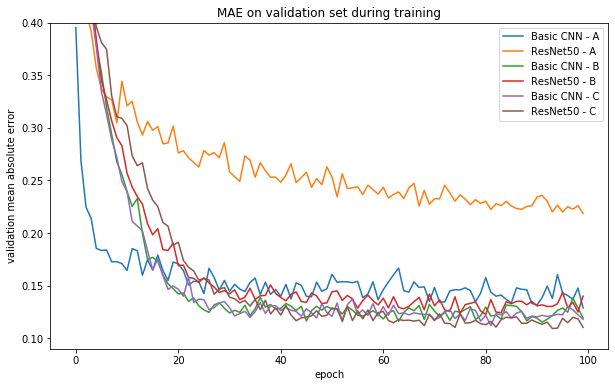

In [177]:
plt.figure(figsize=(10,6))
plt.plot(np.mean(np.array([x.history['val_loss'] for x in basic_cnn_A_histories]), axis=0))
plt.plot(np.mean(np.array([x.history['val_loss'] for x in resnet50_A_histories]), axis=0))
plt.plot(np.mean(np.array([x.history['val_loss'] for x in basic_cnn_B_histories]), axis=0))
plt.plot(np.mean(np.array([x.history['val_loss'] for x in resnet50_B_histories]), axis=0))
plt.plot(np.mean(np.array([x.history['val_loss'] for x in basic_cnn_C_histories]), axis=0))
plt.plot(np.mean(np.array([x.history['val_loss'] for x in resnet50_C_histories]), axis=0))
plt.ylim(0.09,0.4)
plt.xlabel('epoch')
plt.ylabel('validation mean absolute error')
plt.title('MAE on validation set during training')
plt.legend(['Basic CNN - A', 'ResNet50 - A', 'Basic CNN - B', 'ResNet50 - B', 'Basic CNN - C', 'ResNet50 - C'])
plt.show()

In [178]:
model_list = ['Linear regression', 'Random Forest'] + ['ANN Ensemble'] * 7
features_list = (['-'] * 3) + (['Basic CNN', 'ResNet50'] * 3)
architecture_list = ['Baseline'] * 3 + list('AABBCC')
test_scores = pd.DataFrame(
    {'visual features set': features_list,
     'architecture': architecture_list,
     'mean absolute error': mean_errors_list,
     'median absolute error': median_errors_list,
     'R-squared': r2_list},
     index=model_list
)
test_scores.index.rename('model', inplace=True)
test_scores.round(3).to_csv('final results.csv')
test_scores.round(3)

,visual features set,architecture,mean absolute error,median absolute error,R-squared
model,,,,,
Linear regression,-,Baseline,0.138,0.105,0.804
Random Forest,-,Baseline,0.139,0.114,0.802
ANN Ensemble,-,Baseline,0.135,0.102,0.806
ANN Ensemble,Basic CNN,A,0.143,0.112,0.795
ANN Ensemble,ResNet50,A,1.133,0.511,-35.557
ANN Ensemble,Basic CNN,B,0.127,0.101,0.824
ANN Ensemble,ResNet50,B,0.464,0.117,-69.975
ANN Ensemble,Basic CNN,C,0.139,0.111,0.806
ANN Ensemble,ResNet50,C,0.342,0.118,-5.604


In [180]:
errors_summary = pd.concat(errors_summary_list, axis=1).round(3)
errors_summary.columns = model_list
errors_summary.to_csv('errors summary.csv')
errors_summary

,Linear regression,Random Forest,ANN Ensemble,ANN Ensemble,ANN Ensemble,ANN Ensemble,ANN Ensemble,ANN Ensemble,ANN Ensemble
count,340.000,340.000,340.000,340.000,340.000,340.000,340.000,340.000,340.000
mean,0.138,0.139,0.135,0.143,1.133,0.127,0.464,0.139,0.342
std,0.126,0.127,0.128,0.128,2.293,0.124,3.534,0.124,1.032
min,0.000,0.001,0.001,0.001,0.003,0.000,0.001,0.001,0.000
25%,0.050,0.052,0.050,0.054,0.249,0.047,0.057,0.052,0.059
50%,0.105,0.114,0.102,0.112,0.511,0.101,0.117,0.111,0.118
75%,0.204,0.186,0.190,0.190,0.951,0.170,0.212,0.189,0.215
max,0.940,1.144,0.975,0.960,12.899,1.011,46.333,0.997,9.520


In [183]:
data

,transaction_date,postcode,ptype,new_build,energy_consumption_current,energy_consumption_potential,total_floor_area,mains_gas_flag,glazed_type,extension_count,...,mainheatc_energy_eff,construction_age_band,lsoa_code,barriers_score,cyp_score,indoors_score,pop_16_59,older_pop_60,price,bungalow_flag
0,2018-08-21,HP13 6HH,F,N,377,269,64.96,N,double glazing installed before 2002,0.0,...,1,England and Wales: 1967-1975,E01017919,21.025,0.314,0.448,894,250,232000,0
1,2018-12-14,HP12 4AL,S,N,275,68,86.00,Y,double glazing installed before 2002,1.0,...,2,England and Wales: before 1900,E01017853,23.975,-0.325,0.694,835,261,450000,0
2,2018-12-19,HP13 5RH,T,N,175,165,84.48,Y,double glazing unknown install date,0.0,...,3,England and Wales: 1967-1975,E01017860,16.241,0.718,-1.119,869,259,318000,0
3,2018-11-28,HP13 6EA,S,N,327,194,106.00,Y,double glazing unknown install date,2.0,...,3,England and Wales: 1930-1949,E01017919,21.025,0.314,0.448,894,250,420000,0
4,2019-09-26,HP10 8BN,S,N,154,69,130.00,Y,double glazing installed before 2002,2.0,...,3,England and Wales: 1950-1966,E01017942,8.620,-1.121,-1.210,730,459,680000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,2018-09-13,HP12 3UX,S,N,198,78,84.00,Y,double glazing installed before 2002,0.0,...,3,England and Wales: 1950-1966,E01017903,28.638,0.279,0.085,1081,184,285000,0
2563,2018-06-29,HP13 5GJ,F,Y,89,89,68.00,Y,double glazing unknown install date,0.0,...,2,England and Wales: 1950-1966,E01017860,16.241,0.718,-1.119,869,259,310950,0
2564,2019-06-18,HP10 9FT,F,N,286,255,48.00,N,double glazing installed during or after 2002,0.0,...,1,England and Wales: 2003-2006,E01017939,17.138,-0.041,-0.700,807,293,210000,0
2565,2019-04-08,HP13 6GH,T,N,153,136,84.58,Y,double glazing installed before 2002,0.0,...,3,England and Wales: 1996-2002,E01017851,22.409,0.368,-0.488,1147,237,293000,0
